In [1]:
#importing require python deep learning and machine learning packages
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from skimage.io import imshow
import cv2
from keras.layers import  MaxPooling2D
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D
from keras.models import Sequential
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from keras.callbacks import ModelCheckpoint 
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
import os
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn import svm
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn import metrics

In [2]:
X = pd.read_csv("Dataset/sat_images.csv",nrows=3000) #values are in DataFrame format
Y = pd.read_csv("Dataset/satellite_labels.csv",nrows=3000) #values are in DataFrame format
X = np.array(X) # converting Dataframe to numpy array
Y = np.array(Y) # converting Dataframe to numpy array
print("Dataset Loaded")
print("Total Images found in dataset : "+str(X.shape[0]))

Dataset Loaded
Total Images found in dataset : 3000


In [3]:
X = X.reshape([X.shape[0],28,28,4]).astype(float)

Text(0.5, 1.0, 'Sample Process Satellite Image')

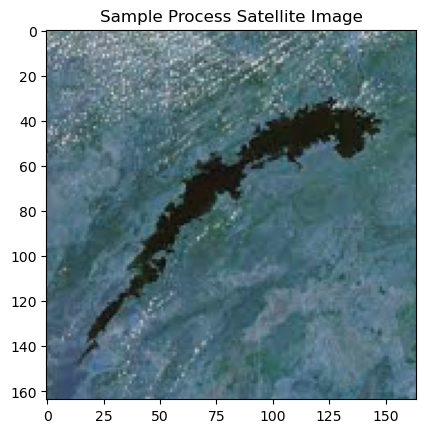

In [4]:
img = cv2.imread("Dataset/drought.jpg")
img = cv2.resize(img, (164,164))
plt.imshow(img/255)
plt.title("Sample Process Satellite Image")

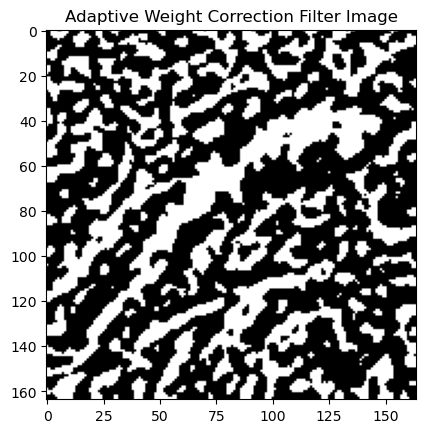

In [5]:
#img_float32 = np.float32(imgs)
#img = cv2.cvtColor(img_float32, cv2.COLOR_RGB2HSV)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (7, 7), 0)
blurred = blurred.astype(np.uint8)
thresh = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 11, 2)
plt.imshow(thresh, cmap="gray")
plt.title("Adaptive Weight Correction Filter Image")
plt.show()

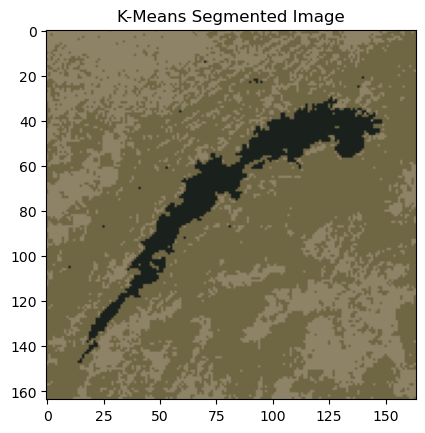

In [6]:
image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
pixel_values = image.reshape((-1, 3))
pixel_values = np.float32(pixel_values)
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)
k = 3
_, labels, (centers) = cv2.kmeans(pixel_values, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
centers = np.uint8(centers)
labels = labels.flatten()
segmented_image = centers[labels.flatten()]
segmented_image = segmented_image.reshape(image.shape)
plt.imshow(segmented_image)
plt.title("K-Means Segmented Image")
plt.show()

In [7]:
X_image = []
for i in range(0,X.shape[0]):
    image = X[i]
    image = image[:,:,:3]
    X_image.append(image)
X_image = np.asarray(X_image)

X = X.astype('float32')
X = X/255
indices = np.arange(X.shape[0])
np.random.shuffle(indices)
X = X[indices]
Y = Y[indices]
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2) #split dataset into train and test
print()
print("80% images are used to train DenseNet169 : "+str(X_train.shape[0]))
print("20% images are used to train DenseNet169 : "+str(X_test.shape[0]))


80% images are used to train DenseNet169 : 2400
20% images are used to train DenseNet169 : 600


In [8]:
#now defining DCNN model layers
dcnn = Sequential()
#creating CNN layer with 32 neurons or filters with 3 X 3 matrix
dcnn.add(Convolution2D(32, (3, 3), input_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3]), activation = 'relu'))
#max pool layer to collect filtered features from CNN previous layer
dcnn.add(MaxPooling2D(pool_size = (2, 2)))
#defining another layer
dcnn.add(Convolution2D(32, (3, 3), activation = 'relu'))
dcnn.add(MaxPooling2D(pool_size = (2, 2)))
dcnn.add(Flatten())
#defining output layer
dcnn.add(Dense(units = 256, activation = 'relu'))
dcnn.add(Dense(units = y_train.shape[1], activation = 'softmax'))
#compiling and loading model
dcnn.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
if os.path.exists("model/model_weights.hdf5") == False:
    model_check_point = ModelCheckpoint(filepath='model/model_weights.hdf5', verbose = 1, save_best_only = True)
    hist = dcnn.fit(X_train, y_train, batch_size = 32, epochs = 20, validation_data=(X_test, y_test), callbacks=[model_check_point], verbose=1)
    f = open('model/history.pckl', 'wb')
    pickle.dump(hist.history, f)
    f.close()    
else:
    dcnn.load_weights("model/model_weights.hdf5")
print(dcnn.summary())    

C:\Users\shaik\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 26, 26, 32)          │           1,184 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 13, 13, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 11, 11, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 5, 5, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 800)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         205,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │           1,028 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 216,516 (845.77 KB)

 Trainable params: 216,516 (845.77 KB)

 Non-trainable params: 0 (0.00 B)

None


In [9]:
#defining global features to store accuracy and other values
accuracy = []
precision = []
recall = [] 
fscore = []

In [10]:
#function to calculate all metrics
def calculateMetrics(algorithm, testY, predict):
    labels = ['Barren land(Drought)', 'Forest land', 'Grassland', 'Others']
    p = precision_score(testY, predict,average='macro') * 100
    r = recall_score(testY, predict,average='macro') * 100
    f = f1_score(testY, predict,average='macro') * 100
    a = accuracy_score(testY,predict)*100
    accuracy.append(a)
    precision.append(p)
    recall.append(r)
    fscore.append(f)
    print(algorithm+" Accuracy  : "+str(a))
    print(algorithm+" Precision : "+str(p))
    print(algorithm+" Recall    : "+str(r))
    print(algorithm+" FSCORE    : "+str(f))
    conf_matrix = confusion_matrix(testY, predict)
    fig, axs = plt.subplots(1,2,figsize=(12, 6))
    ax = sns.heatmap(conf_matrix, xticklabels = labels, yticklabels = labels, annot = True, cmap="viridis" ,fmt ="g", ax=axs[0]);
    ax.set_ylim([0,len(labels)])
    axs[0].set_title(algorithm+" Confusion matrix") 

    random_probs = [0 for i in range(len(testY))]
    p_fpr, p_tpr, _ = roc_curve(testY, random_probs, pos_label=1)
    plt.plot(p_fpr, p_tpr, linestyle='--', color='orange',label="True classes")
    ns_fpr, ns_tpr, _ = roc_curve(testY, predict, pos_label=1)
    axs[1].plot(ns_tpr, ns_fpr, linestyle='--', label='Predicted Classes')
    axs[1].set_title(algorithm+" ROC AUC Curve")
    axs[1].set_xlabel('False Positive Rate')
    axs[1].set_ylabel('True Positive rate')
    plt.show()

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Propose DCNN Algorithm Accuracy  : 97.33333333333334
Propose DCNN Algorithm Precision : 97.28760014944581
Propose DCNN Algorithm Recall    : 96.80952292466417
Propose DCNN Algorithm FSCORE    : 97.03325928246889


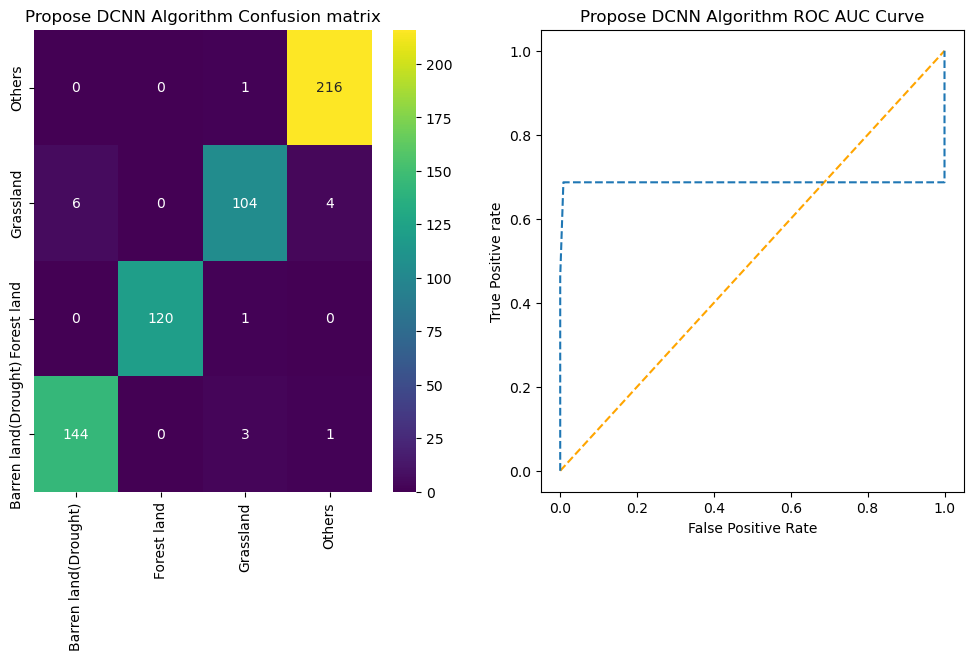

In [11]:
#now using DCNN perform prediction on test data and calculate accuracy and other metrics
predict = dcnn.predict(X_test)
predict = np.argmax(predict, axis=1)
y_test1 = np.argmax(y_test, axis=1)
calculateMetrics("Propose DCNN Algorithm", y_test1, predict)

Existing SVM Algorithm Accuracy  : 89.16666666666667
Existing SVM Algorithm Precision : 90.37061941609254
Existing SVM Algorithm Recall    : 87.47199644907624
Existing SVM Algorithm FSCORE    : 88.58922642718954


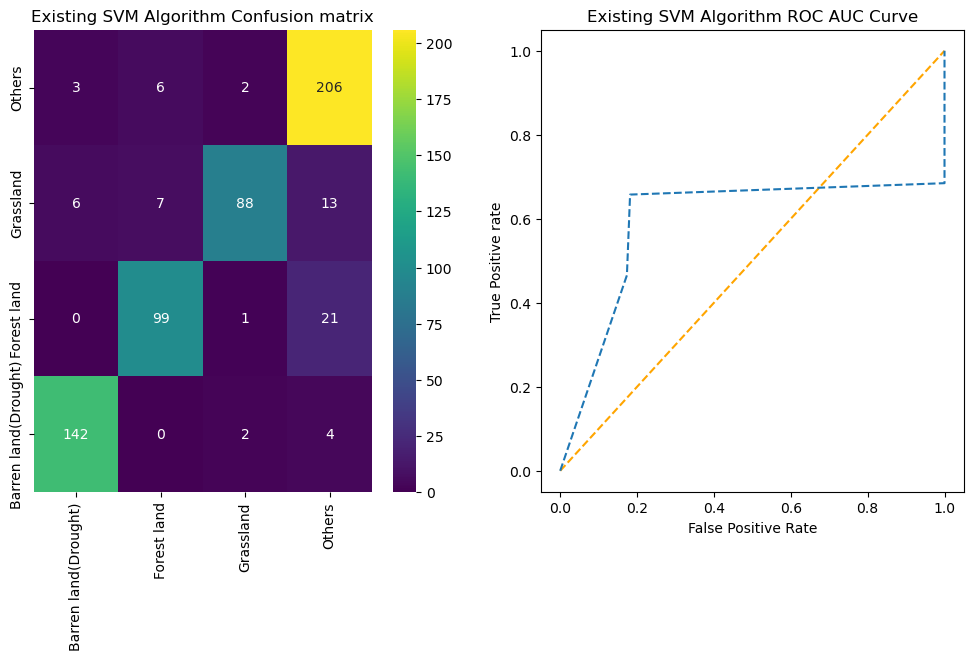

In [12]:
#now training SVM algortihm on satellite images
X_train1 = np.reshape(X_train, (X_train.shape[0], (X_train.shape[1] * X_train.shape[2] * X_train.shape[3])))
X_test1 = np.reshape(X_test, (X_test.shape[0], (X_test.shape[1] * X_test.shape[2] * X_test.shape[3])))
y_train1 = np.argmax(y_train, axis=1)
y_test1 = np.argmax(y_test, axis=1)
svm_cls = svm.SVC()#defining SVM object
svm_cls.fit(X_train1, y_train1)#train SVM
predict = svm_cls.predict(X_test1)#perform prediction on test data
calculateMetrics("Existing SVM Algorithm", y_test1, predict)

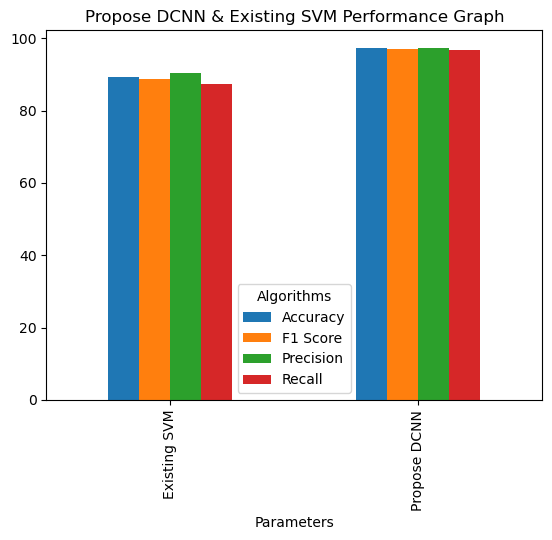

In [13]:
#now plot accuracy and other metrics comparison graph
df = pd.DataFrame([['Propose DCNN','Precision',precision[0]],['Propose DCNN','Recall',recall[0]],['Propose DCNN','F1 Score',fscore[0]],['Propose DCNN','Accuracy',accuracy[0]],
                   ['Existing SVM','Precision',precision[1]],['Existing SVM','Recall',recall[1]],['Existing SVM','F1 Score',fscore[1]],['Existing SVM','Accuracy',accuracy[1]],
                  ],columns=['Parameters','Algorithms','Value'])
df.pivot(index="Parameters", columns="Algorithms", values="Value").plot(kind='bar')
plt.title("Propose DCNN & Existing SVM Performance Graph")
plt.show()

In [14]:
#Performance of all algorithms in tabular format
columns = ["Algorithm Name","Accuracy", "Precision", "Recall", "FSCORE"]
values = []
algorithm_names = ['Propose DCNN', 'Existing SVM']
for i in range(len(algorithm_names)):
    values.append([algorithm_names[i],accuracy[i],precision[i],recall[i],fscore[i]])
    
temp = pd.DataFrame(values,columns=columns)
temp

,Algorithm Name,Accuracy,Precision,Recall,FSCORE
0,Propose DCNN,97.333333,97.287600,96.809523,97.033259
1,Existing SVM,89.166667,90.370619,87.471996,88.589226


In [15]:
def predict(input_image_path):#function to perform prediction on given input test image path
    image = cv2.imread(input_image_path) #read image
    image = cv2.cvtColor(image, cv2.COLOR_BGR2BGRA)#convert it as a satllite image
    img = cv2.resize(image, (28, 28)) #resize image
    im2arr = np.array(img)
    im2arr = im2arr.reshape(1,28,28,4)#make images as multi dimension
    img = np.asarray(im2arr)
    img = img.astype('float32')#convert image as float type
    img = img/255#normalize image
    preds = dcnn.predict(img) #perform prediction on image as drought or no drought
    predict = np.argmax(preds)
    img = cv2.imread(input_image_path)
    img = cv2.resize(img, (700,400))
    if predict == 0 or predict == 1:
        cv2.putText(img, 'Drought Detected', (10, 45),  cv2.FONT_HERSHEY_SIMPLEX,2.0, (255, 0, 0), 4)
    else:
        cv2.putText(img, 'No Drought Detected', (10, 45),  cv2.FONT_HERSHEY_SIMPLEX,2.0, (255, 0, 0), 4)
    plt.imshow(img)    

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


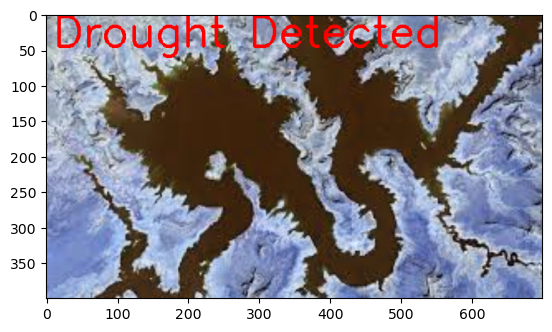

In [16]:
#calling predict function to predict drought or no drought
predict("testImages/1.jpg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


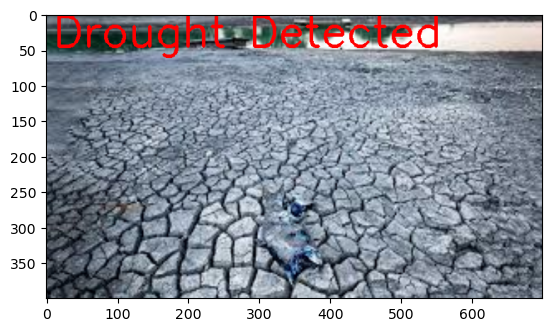

In [17]:
#calling predict function to predict drought or no drought
predict("testImages/2.jpg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


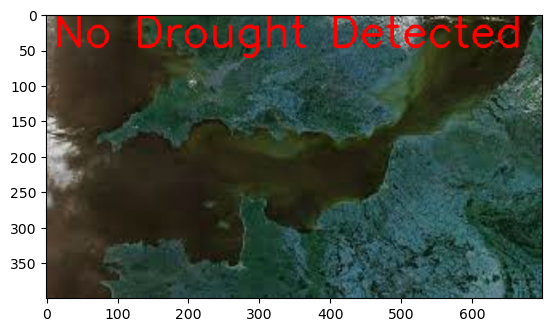

In [18]:
#calling predict function to predict drought or no drought
predict("testImages/3.jpg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


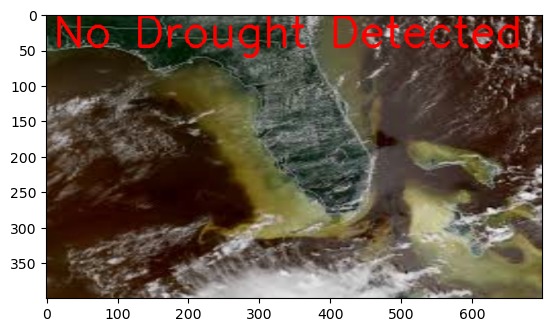

In [19]:
#calling predict function to predict drought or no drought
predict("testImages/4.jpg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


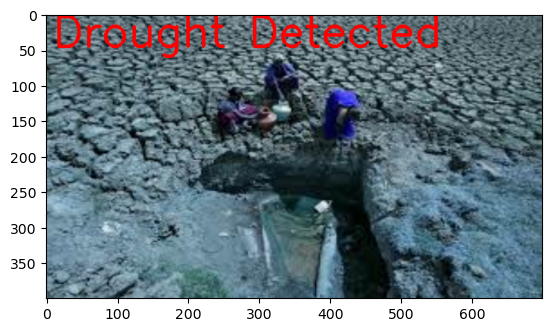

In [20]:
#calling predict function to predict drought or no drought
predict("testImages/images.jpg")